# Dynamic Task and Weight Prioritization Curriculum Learning for Multimodal Imagery
## Evaluation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms, models

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from PIL import Image
import numpy as np
import random
import os
import json
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from character_mappings import *

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Load Hyperparameters

In [2]:
with open('results_and_history/hyperparameters.json', 'r') as f:
    hyperparameters = json.load(f)

# Convert String Keys into Integers
* Side effect of using JSON

In [3]:
temp_dict = {}

for k,v in hyperparameters['DATASET']['ANSWERS_DICT'].items():
    #print(k, k.isnumeric())
    if k.isnumeric():
        temp_dict[int(k)] = v
    else:
        temp_dict[k] = v

In [4]:
hyperparameters['DATASET']['ANSWERS_DICT'] = temp_dict

# Seed everything

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

print('Seed:', hyperparameters['SEED'])
seed_everything(hyperparameters['SEED'])

Seed: 99999


# Dataset

### Full Dataset

In [6]:
#from custom_datasets.cached import FloodnetCachedDataset
from custom_datasets.non_cached import FloodnetDataset

In [7]:
hyperparameters['DATASET']['TRAIN_QUESTIONS_PATH']

'../../data/FloodNet/track2_vqa/Questions/Training Question.json'

In [8]:
with open(hyperparameters['DATASET']['TRAIN_QUESTIONS_PATH'], 'r') as f:
    train_questions = json.load(f)
    
train_ds_len = len(train_questions)
train_ds_len

4511

# NOTE: IS IT A GOOD IDEA TO SPLIT TRAIN 
## USE CL TO MAKE SPLITS (MUSTAFA HOCA)

In [9]:
questions_list = list(train_questions.values())
questions_list[:2]

[{'Image_ID': '10165.JPG',
  'Question': 'What is the overall condition of the given image?',
  'Ground_Truth': 'flooded',
  'Question_Type': 'Condition_Recognition'},
 {'Image_ID': '10166.JPG',
  'Question': 'What is the overall condition of the given image?',
  'Ground_Truth': 'flooded',
  'Question_Type': 'Condition_Recognition'}]

In [10]:
img_transforms = A.Compose([
    A.Resize(width=hyperparameters['IMAGE']['RES'], height=hyperparameters['IMAGE']['RES']),
])


full_train_dataset = FloodnetDataset(
    train_images_path=hyperparameters['DATASET']['TRAIN_IMAGES_PATH'],
    mask_images_path=hyperparameters['DATASET']['MASK_IMAGES_PATH'],
    img_transforms=img_transforms,
    num_segmentation_classes=hyperparameters['IMAGE']['NUM_SEG_CLASSES'],
    questions_list=questions_list,
    answers_dict=hyperparameters['DATASET']['ANSWERS_DICT'],
    char2idx=char2idx, # from character_mappings.py
    idx2char=idx2char, # from character_mappings.py
    question_type_dict=hyperparameters['DATASET']['QUESTION_TYPE_DICT'], 
    max_question_len='auto',
    use_average_len=False,
)


ds_sample = full_train_dataset[0]

Average question length: 51
Maximum question length: 70


In [11]:
print(ds_sample[0].shape)
print(ds_sample[1].shape)
print(ds_sample[2].shape)
print(ds_sample[3].shape)
print(ds_sample[4])
print(ds_sample[5])

torch.Size([3, 200, 200])
torch.Size([10, 200, 200])
torch.Size([70])
torch.Size([70])
0
0


### Get all answers used in training

In [12]:
train_questions_list = [questions_list[i] for i in hyperparameters['DATASET']['TRAIN_DATASET_IDX']] 
val_questions_list = [questions_list[i] for i in hyperparameters['DATASET']['VAL_DATASET_IDX']] 
test_questions_list = [questions_list[i] for i in hyperparameters['DATASET']['TEST_DATASET_IDX']] 

In [13]:
train_dataset = FloodnetDataset(
    train_images_path=hyperparameters['DATASET']['TRAIN_IMAGES_PATH'],
    mask_images_path=hyperparameters['DATASET']['MASK_IMAGES_PATH'],
    img_transforms=img_transforms,
    num_segmentation_classes=hyperparameters['IMAGE']['NUM_SEG_CLASSES'],
    questions_list=train_questions_list,
    answers_dict=hyperparameters['DATASET']['ANSWERS_DICT'],
    char2idx=char2idx, # from character_mappings.py
    idx2char=idx2char, # from character_mappings.py
    question_type_dict=hyperparameters['DATASET']['QUESTION_TYPE_DICT'], 
    max_question_len='auto',
    use_average_len=False,
)

val_dataset = FloodnetDataset(
    train_images_path=hyperparameters['DATASET']['TRAIN_IMAGES_PATH'],
    mask_images_path=hyperparameters['DATASET']['MASK_IMAGES_PATH'],
    img_transforms=img_transforms,
    num_segmentation_classes=hyperparameters['IMAGE']['NUM_SEG_CLASSES'],
    questions_list=val_questions_list,
    answers_dict=hyperparameters['DATASET']['ANSWERS_DICT'],
    char2idx=char2idx, # from character_mappings.py
    idx2char=idx2char, # from character_mappings.py
    question_type_dict=hyperparameters['DATASET']['QUESTION_TYPE_DICT'], 
    max_question_len='auto',
    use_average_len=False,
)


test_dataset = FloodnetDataset(
    train_images_path=hyperparameters['DATASET']['TRAIN_IMAGES_PATH'],
    mask_images_path=hyperparameters['DATASET']['MASK_IMAGES_PATH'],
    img_transforms=img_transforms,
    num_segmentation_classes=hyperparameters['IMAGE']['NUM_SEG_CLASSES'],
    questions_list=test_questions_list,
    answers_dict=hyperparameters['DATASET']['ANSWERS_DICT'],
    char2idx=char2idx, # from character_mappings.py
    idx2char=idx2char, # from character_mappings.py
    question_type_dict=hyperparameters['DATASET']['QUESTION_TYPE_DICT'], 
    max_question_len='auto',
    use_average_len=False,
)

Average question length: 51
Maximum question length: 70
Average question length: 51
Maximum question length: 70
Average question length: 51
Maximum question length: 70


In [14]:
len(train_dataset.answers_dict)

41

# Dataloader

In [15]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=hyperparameters['BATCH_SIZE'],
    shuffle=hyperparameters['SHUFFLE'],
    num_workers=hyperparameters['NUM_WORKERS'],
    pin_memory=hyperparameters['PIN_MEMORY'],
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=hyperparameters['BATCH_SIZE'],
    shuffle=hyperparameters['SHUFFLE'],
    num_workers=hyperparameters['NUM_WORKERS'],
    pin_memory=hyperparameters['PIN_MEMORY'],
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=hyperparameters['BATCH_SIZE'],
    shuffle=hyperparameters['SHUFFLE'],
    num_workers=hyperparameters['NUM_WORKERS'],
    pin_memory=hyperparameters['PIN_MEMORY'],
)

In [16]:
print(f'Number of batches, train: {len(train_dataloader)}, val: {len(val_dataloader)}, test: {len(test_dataloader)}')

Number of batches, train: 395, val: 85, test: 85


# Model

In [17]:
from models.segmentation import UNet
from models.vqa import VQAClassifier

In [18]:
unet = UNet(
    in_channels=hyperparameters['IMAGE']['IN_CHANNELS'], 
    n_classes=hyperparameters['IMAGE']['NUM_SEG_CLASSES'], 
    features=hyperparameters['IMAGE']['FEATURES'], 
    relu_inplace=hyperparameters['IMAGE']['RELU_INPLACE']
)

In [19]:
model = VQAClassifier(
    n_char_tokens=hyperparameters['TEXT']['N_CHAR_TOKENS'], 
    emb_dim=hyperparameters['TEXT']['EMB_DIM'], 
    pos_emb_dropout=hyperparameters['TEXT']['POS_EMB_DROPOUT'], 
    max_question_len=hyperparameters['DATASET']['MAX_QUESTION_LEN'], 
    n_vqa_answer_classes=hyperparameters['DATASET']['NUM_VQA_ANSWER_CLASSES'],
    #n_vqa_question_type_classes=NUM_VQA_QUESTION_TYPE_CLASSES,
    unet=unet,
    unet_features_dim=hyperparameters['IMAGE']['UNET_FEATURES_DIM'],
    image_features_pool_dim=hyperparameters['IMAGE']['RES_UNET_SIZES'][str(hyperparameters['IMAGE']['RES'])], # Side effect of using JSON
    freeze_unet=hyperparameters['TEXT']['FREEZE_UNET'],
    text_dropout_prob=hyperparameters['TEXT']['TEXT_DROPOUT_PROB'],
    combined_dropout_prob=hyperparameters['TEXT']['COMBINED_DROPOUT_PROB'],
)

Total (image+text) features: 703


/home/shodan/Documents/deep_learning/pytorch/thesis/PUBLICATIONS/publication_1_v2/models/vqa.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pe_tensor = torch.tensor(


### Load Pre-trained Model

In [20]:
MODEL_SAVE_PATH = os.path.join(hyperparameters['MODELS_FOLDER'], f"VQAClassifier_{hyperparameters['IMAGE']['RES']}_checkpoint.pth")
checkpoint = torch.load(MODEL_SAVE_PATH)

In [21]:
model.image_encoder.load_state_dict(checkpoint['unet_state_dict'], strict=True)

<All keys matched successfully>

In [22]:
model.load_state_dict(checkpoint['model_state_dict'], strict=True)

<All keys matched successfully>

# Evaluate The Model

In [23]:
model.eval()
model.to(device)
print() # prevent printing lots of stuff

### Overall Performance

In [24]:
from learning.segmentation_metrics import calculate_segmentation_metrics

In [25]:
@torch.no_grad()
def overall_metrics(dataloader, model, answer_dict, question_type_dict):
    model.eval()

    #################### SEGMENTATION #####################
    #######################################################
    segmentation_metrics = calculate_segmentation_metrics(dataloader, model, device, threshold=0.5, eplison=1e-8)

    dice = segmentation_metrics['avg_dice_score']
    miou = segmentation_metrics['miou_score']
    
    print('Overall Segmentation:')
    print(f"Dice: {dice:.2f}, mIoU: {miou:.2f}")
    print('######################')
    print()
    #######################################################
    #######################################################

    n_answer_correct = 0
    acc_count = 0
    
    pbar = tqdm(dataloader, unit='batch')
    pbar.set_description(f'Test per class')
    
    for image, masks, question_tokens, pad_mask, question_type_ids, answer_ids in pbar:
        # SEG
        image, masks = image.to(device), masks.to(device) 
        # VQA
        question_tokens, pad_mask, answer_ids = question_tokens.to(device), pad_mask.to(device), answer_ids.to(device)

        answer_predictions, attn_scores, mask_predictions = model(image, question_tokens, pad_mask)

         # Answer accuracy
        pred_answer_ids = answer_predictions.argmax(dim=-1)
        
        acc_count += answer_ids.size(0) # (batch size)
        n_answer_correct += (answer_ids == pred_answer_ids).sum().item()

    avg_answer_acc = (100 * n_answer_correct) / acc_count
    
    print(f'Overall answer accuracy: %{avg_answer_acc:.2f}')

### Validation Results

In [26]:
overall_metrics(
    val_dataloader, 
    model, 
    hyperparameters['DATASET']['ANSWERS_DICT'], 
    hyperparameters['DATASET']['QUESTION_TYPE_DICT']
)

Overall Segmentation:
Dice: 80.69, mIoU: 67.89
######################



Test per class: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:48<00:00,  1.76batch/s]

Overall answer accuracy: %77.25


### Test Results

In [27]:
overall_metrics(
    test_dataloader, 
    model, 
    hyperparameters['DATASET']['ANSWERS_DICT'], 
    hyperparameters['DATASET']['QUESTION_TYPE_DICT']
)

Overall Segmentation:
Dice: 80.30, mIoU: 67.50
######################



Test per class: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s]

Overall answer accuracy: %77.99


### Per class metrics

In [28]:
def calculate_dice_and_miou(mask, mask_predictions, threshold=0.5, eplison=1e-8):
    model.eval()
    
    preds = torch.sigmoid(mask_predictions)
    preds = (preds > threshold).float()

    # Dice score
    dice_score = (2 * (preds * mask).sum()) / (
        (preds + mask).sum() + eplison
    )

    # intersection is equivalent to True Positive (TP) count
    # union is the mutually inclusive area of all labels & predictions 
    intersection = (preds * mask).sum()
    total = (preds + mask).sum()
    union = total - intersection 

    mIoU_score = intersection/(union + eplison)

    return dice_score, mIoU_score
    
    
def answer_accuracy_per_type(dataloader, model, seg_class_names, answer_dict, question_type_dict):
    model.eval()
    model.to(device)
    
    pbar = tqdm(dataloader, unit='batch')
    pbar.set_description(f'Test per class')

    classes = list(answer_dict.keys())
    question_types = list(question_type_dict.keys())

    answers_dict_reversed = {v:k for k,v in answer_dict.items()}
    question_type_dict_reversed = {v:k for k,v in question_type_dict.items()}
    
    correct_pred = {classname: [] for classname in classes}
    qt_correct_pred = {qt: [] for qt in question_types}
    
    # SEG dicts
    dice_per_mask = {classname: [] for classname in seg_class_names}
    mIoU_per_mask = {classname: [] for classname in seg_class_names}
    
    
    for image, masks, question_tokens, pad_mask, question_type_ids, answer_ids in pbar:
        # SEG
        image, masks = image.to(device), masks.to(device) 
        # VQA
        question_tokens, pad_mask, answer_ids = question_tokens.to(device), pad_mask.to(device), answer_ids.to(device)
        
        with torch.no_grad():
            answer_predictions, attn_scores, mask_predictions = model(image, question_tokens, pad_mask)

            answer_predictions = answer_predictions.argmax(dim=-1)

            for label, qt, prediction in zip(answer_ids, question_type_ids, answer_predictions):
                if label == prediction:
                    correct_pred[answers_dict_reversed[label.item()]].append(1)
                    qt_correct_pred[question_type_dict_reversed[qt.item()]].append(1)
                else:
                    correct_pred[answers_dict_reversed[label.item()]].append(0)
                    qt_correct_pred[question_type_dict_reversed[qt.item()]].append(0)

            # Segmentation per class
            for mask_id, classname in enumerate(seg_class_names):
                non_zero_ids = [(masks[batch_id, mask_id, :, :].sum() != 0).item() for batch_id in range(masks.shape[0])]

                masks_selected = masks[non_zero_ids, mask_id, :, :]
                mask_predictions_selected = mask_predictions[non_zero_ids, mask_id, :, :]
                
                dice_score, mIoU_score = calculate_dice_and_miou(masks_selected, mask_predictions_selected)

                dice_per_mask[seg_class_names[mask_id]].append(dice_score.item())
                mIoU_per_mask[seg_class_names[mask_id]].append(mIoU_score.item())
                    

    
    results = {
        'dice_score': {},
        'mIoU_score': {},
        'accuracy_per_question_type': {},
        'accuracy_per_answer_class': {},
    }
    
    
    print('*** DICE PER CLASS ***')
    for classname, score in dice_per_mask.items():
        
        #if classname == 'Building-flooded':
        #    print(f'__score: {score}')
        #    return
        
        try:
            #_score = 100 * score.item() / len(dataloader)
            _score = 100 * (sum(score) / len(score))
            
            print(f'Dice for class: {classname:22s} is {_score:.2f}%')
            results['dice_score'][classname] = _score
        except:
            print(f'ERROR at: {classname}, correct_count: {score}')
            results['dice_score'][classname] = -1
            
    print('\n\n')
       
        
    print('*** mIoU PER CLASS ***')
    for classname, score in mIoU_per_mask.items():
        try:
            #_score = 100 * score.item() / len(dataloader)
            _score = 100 * (sum(score) / len(score))
            print(f'mIoU for class: {classname:22s} is {_score:.2f}%')
            results['mIoU_score'][classname] = _score
        except:
            print(f'ERROR at: {classname}, correct_count: {score}')    
            results['mIoU_score'][classname] = -1
            
    print('\n\n')
        
        
    print('*** ACCURACY PER QUESTION TYPE ***')
    for classname, correct_count in qt_correct_pred.items():
        try:
            #accuracy = 100 * float(correct_count) / total_pred_qt[classname]
            #accuracy = 100.0 * correct_count / total_pred_qt[classname]
            accuracy = 100.0 * (sum(correct_count) / len(correct_count))
            print(f'__correct_count: {len(correct_count)}')
            #if classname == '':
            #    return
            print(f'Accuracy for class: {classname:22s} is {accuracy:.1f}%')
            results['accuracy_per_question_type'][classname] = accuracy
        except:
            print(f'ERROR at: {classname}, correct_count: {correct_count}')
            results['accuracy_per_question_type'][classname] = -1
                    
    print('\n\n')
    

    """
    print('*** ACCURACY PER ANSWER TYPE ***')
    for classname, correct_count in correct_pred.items():
        try:
            #accuracy = 100 * float(correct_count) / total_pred[classname]
            #accuracy = 100.0 * correct_count / total_pred[classname]
            accuracy = 100.0 * (sum(correct_count) / len(correct_count))
            
            print(f'Accuracy for class: {classname:22s} is {accuracy:.1f}%')
            results['accuracy_per_answer_class'][classname] = accuracy
        except:
            print(f'ERROR at: {classname}, correct_count: {correct_count}')
            results['accuracy_per_answer_class'][classname] = -1
    """
    
    return results

### Validation Results

In [29]:
val_results = answer_accuracy_per_type(
    val_dataloader, 
    model, 
    hyperparameters['IMAGE']['SEG_CLASS_NAMES'],
    hyperparameters['DATASET']['ANSWERS_DICT'], 
    hyperparameters['DATASET']['QUESTION_TYPE_DICT']
)

Test per class: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:48<00:00,  1.74batch/s]

*** DICE PER CLASS ***
Dice for class: Background             is 0.58%
Dice for class: Building-flooded       is 60.01%
Dice for class: Building-non-flodded   is 71.37%
Dice for class: Road-flooded           is 50.99%
Dice for class: Road-non-flooded       is 71.67%
Dice for class: Water                  is 72.58%
Dice for class: Tree                   is 83.89%
Dice for class: Vehicle                is 29.10%
Dice for class: Pool                   is 47.25%
Dice for class: Grass                  is 89.15%



*** mIoU PER CLASS ***
mIoU for class: Background             is 0.31%
mIoU for class: Building-flooded       is 49.68%
mIoU for class: Building-non-flodded   is 58.30%
mIoU for class: Road-flooded           is 39.24%
mIoU for class: Road-non-flooded       is 57.49%
mIoU for class: Water                  is 60.18%
mIoU for class: Tree                   is 72.48%
mIoU for class: Vehicle                is 17.92%
mIoU for class: Pool                   is 35.65%
mIoU for class: Grass 

### Test Results

In [30]:
test_results = answer_accuracy_per_type(
    test_dataloader, 
    model, 
    hyperparameters['IMAGE']['SEG_CLASS_NAMES'],
    hyperparameters['DATASET']['ANSWERS_DICT'], 
    hyperparameters['DATASET']['QUESTION_TYPE_DICT']
)

Test per class: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:48<00:00,  1.75batch/s]

*** DICE PER CLASS ***
Dice for class: Background             is 0.84%
Dice for class: Building-flooded       is 57.96%
Dice for class: Building-non-flodded   is 68.04%
Dice for class: Road-flooded           is 50.08%
Dice for class: Road-non-flooded       is 70.10%
Dice for class: Water                  is 71.37%
Dice for class: Tree                   is 83.69%
Dice for class: Vehicle                is 30.52%
Dice for class: Pool                   is 46.13%
Dice for class: Grass                  is 88.29%



*** mIoU PER CLASS ***
mIoU for class: Background             is 0.48%
mIoU for class: Building-flooded       is 47.87%
mIoU for class: Building-non-flodded   is 54.76%
mIoU for class: Road-flooded           is 38.94%
mIoU for class: Road-non-flooded       is 55.19%
mIoU for class: Water                  is 58.86%
mIoU for class: Tree                   is 72.30%
mIoU for class: Vehicle                is 18.83%
mIoU for class: Pool                   is 34.55%
mIoU for class: Grass 

# Final Class Weights

In [31]:
def print_dynamic_weigths():
    save_path = os.path.join(hyperparameters['RESULTS_AND_HISTORY_FOLDER'], 'dynamic_weights.json')
    
    with open(save_path, 'r') as f:
        dynamic_weights_plain = json.load(f)

    answer_dict_reversed = {v:k for k,v in hyperparameters['DATASET']['ANSWERS_DICT'].items()}

    # Since there are many "Counting" classes, average them
    counting_weights = []
    
    for _class_id, _weight in dynamic_weights_plain.items():
        answer = answer_dict_reversed[int(_class_id)]
        
        if isinstance(answer, int):
            counting_weights.append(_weight)
            continue
        print(f'Answer: {answer_dict_reversed[int(_class_id)]:<20} Weigth: {_weight:.4f}')

    counting_weights_average = sum(counting_weights)/len(counting_weights)
    print(f'Answer: {"counting (average)":<20} Weigth: {counting_weights_average:4f}')

In [32]:
print_dynamic_weigths()

Answer: flooded              Weigth: 1.0039
Answer: non flooded          Weigth: 2.2706
Answer: Yes                  Weigth: 1.2639
Answer: No                   Weigth: 1.2700
Answer: flooded,non flooded  Weigth: 0.9515
Answer: counting (average)   Weigth: 0.917524


# Test VQA

In [33]:
model.to('cpu')
print()

# Full resolution VQA qustion answer pair
* This part is only added for publication purposes

In [34]:
save_dir = lambda filename: os.path.join(hyperparameters['RESULTS_AND_HISTORY_FOLDER'], filename)

# Select from Batch ID
* This part selects from batch of data

In [35]:
__answer_dict_reversed = {v:k for k,v in hyperparameters['DATASET']['ANSWERS_DICT'].items()}

In [36]:
test_iter = iter(test_dataloader)

In [37]:
test_image, test_masks, test_question_tokens, test_pad_mask, test_question_type_ids, test_answer_ids = next(test_iter)
answer_predictions_test, attn_scores_test, final_output_test = model(test_image, test_question_tokens, test_pad_mask)

Answer, pred: non flooded, actual: non flooded


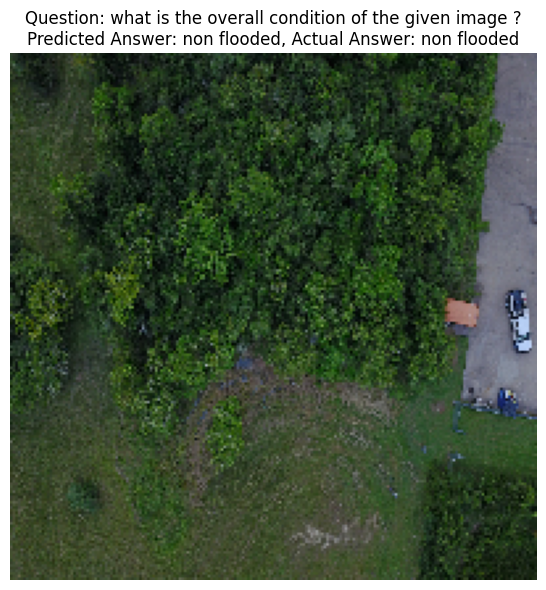

In [38]:
BATCH_ID = -1

answer_predictions_test_selected = answer_predictions_test[BATCH_ID]
attn_scores_test_selected = attn_scores_test[BATCH_ID]

# Image 
test_image_selected = test_image[BATCH_ID]
# VQA
test_question_tokens_selected = test_question_tokens[BATCH_ID]
test_answer_ids_selected = test_answer_ids[BATCH_ID]
test_question_type_ids_selected = test_question_type_ids[BATCH_ID]
# SEG
final_output_test_selected = final_output_test[BATCH_ID]
test_masks_selected = test_masks[BATCH_ID]

# VQA
answer_pred_test_str = __answer_dict_reversed[answer_predictions_test_selected.argmax(dim=-1).item()]
answer_actual_test_str = __answer_dict_reversed[test_answer_ids_selected.item()]
print(f'Answer, pred: {answer_pred_test_str}, actual: {answer_actual_test_str}')

question_ans_str = f'Question: {convert_to_char(test_question_tokens_selected.tolist(), idx2char)}?\nPredicted Answer: {answer_pred_test_str}, Actual Answer: {answer_actual_test_str}'


plt.figure(figsize=(12, 6))
plt.axis('off')
plt.title(question_ans_str)
plt.tight_layout()
plt.imshow(test_image_selected.permute(1,2,0).numpy())
plt.savefig(save_dir('vqa_pair.eps'), format='eps')

### Answer Prediction

In [39]:
answer_pred_test_str = __answer_dict_reversed[answer_predictions_test_selected.argmax(dim=-1).item()]
answer_actual_test_str = __answer_dict_reversed[test_answer_ids_selected.item()]
print(f'Answer, pred: {answer_pred_test_str}, actual: {answer_actual_test_str}')

Answer, pred: non flooded, actual: non flooded


### Custom question VQA 

In [40]:
def answer_custom_question(test_image, q_sentence, __answer_dict_reversed, plot_attention=False):
    model.eval()
    
    q_tokens, q_pad_mask = full_train_dataset.generate_question_tokens(q_sentence)
    answer_predictions_custom, attn_scores_custom, _ = model(test_image.unsqueeze(0), q_tokens.unsqueeze(0), q_pad_mask.unsqueeze(0))

    answer_pred_custom_str = __answer_dict_reversed[answer_predictions_custom.argmax(dim=-1).item()]
    
    answer_conficence = torch.softmax(answer_predictions_custom, dim=-1).max().item()
    
    print(f'Question: {q_sentence}\nPredicted answer: {answer_pred_custom_str}, confidence: {answer_conficence:.2f}')

    
    if plot_attention:
        characters = [idx2char[c] for c in q_tokens.tolist()]
        attention_scores = attn_scores_custom.detach().numpy()[0]

        df_attn = pd.DataFrame({
            'Tokens': characters,
            'Scores': attention_scores,
        })
        
        df_attn = df_attn[df_attn.Tokens != '<pad>']
        df_attn.plot.bar(x='Tokens', y='Scores', rot=0, figsize=(22, 5), grid='on', title=f'Question: {q_sentence}')

In [41]:
answer_custom_question(test_image_selected, 'what is the condition of the road ?', __answer_dict_reversed)

Question: what is the condition of the road ?
Predicted answer: non flooded, confidence: 1.00


In [42]:
answer_custom_question(test_image_selected, 'how many trees are there ?', __answer_dict_reversed)

Question: how many trees are there ?
Predicted answer: 1, confidence: 0.64


In [43]:
answer_custom_question(test_image_selected, 'how many trees are in this image ?', __answer_dict_reversed)

Question: how many trees are in this image ?
Predicted answer: 1, confidence: 0.64


In [44]:
answer_custom_question(test_image_selected, 'how many building are in this image ?', __answer_dict_reversed)

Question: how many building are in this image ?
Predicted answer: 1, confidence: 0.44


In [45]:
answer_custom_question(test_image_selected, 'how many building are non flooded in this image ?', __answer_dict_reversed)

Question: how many building are non flooded in this image ?
Predicted answer: 1, confidence: 0.75


# Test Segmentation

In [46]:
predictions = torch.sigmoid(final_output_test_selected)
predictions.max()

tensor(0.9995, grad_fn=<MaxBackward1>)

### Prediction Threshold & Select image from batch

In [47]:
THRESHOLD = 0.5
predictions_threshold = (predictions > THRESHOLD).float()

### Plot selected image

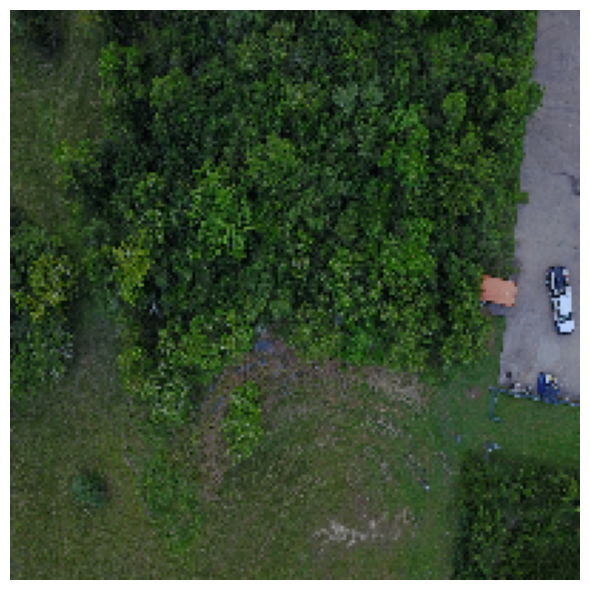

In [48]:
plt.figure(figsize=(8, 6))
plt.axis('off')
#plt.title('Test image')
plt.imshow(test_image_selected.permute(1,2,0).numpy())
plt.tight_layout()
plt.savefig(save_dir('segmentation_image.eps'), format='eps')

### Predicted Masks

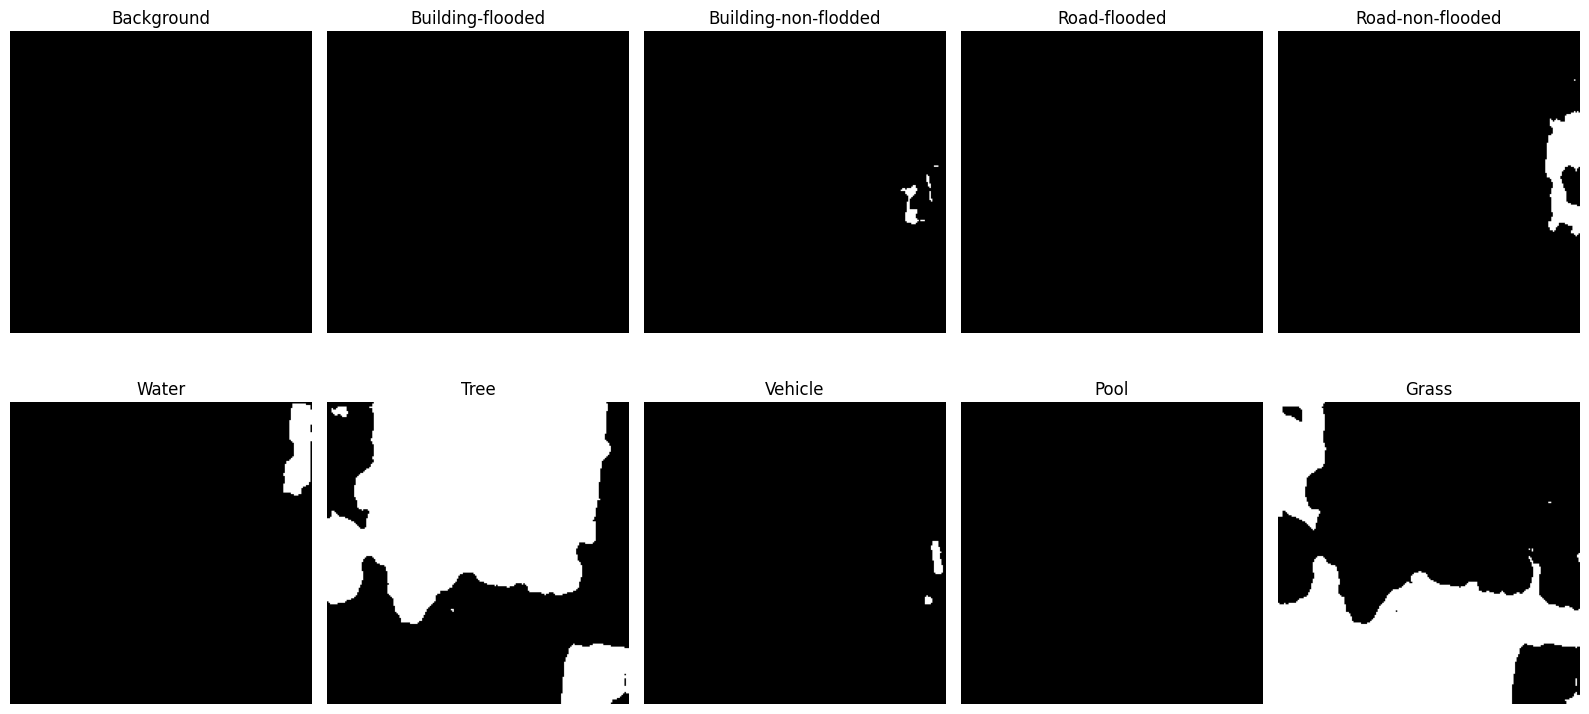

In [49]:
plt.figure(figsize=(16, 8)) 

for class_id in range(1, hyperparameters['IMAGE']['NUM_SEG_CLASSES']+1):
    plt.subplot(2, 5, class_id)
    plt.title(hyperparameters['IMAGE']['SEG_CLASS_NAMES'][class_id-1])
    
    __img = predictions_threshold[class_id-1,:,:].cpu().detach()

    plt.axis('off')
    plt.imshow(__img, cmap='gray')
    
plt.tight_layout()
plt.savefig(save_dir('masks_prediction.eps'), format='eps')

In [50]:
test_masks.shape

torch.Size([8, 10, 200, 200])

### Actual Masks

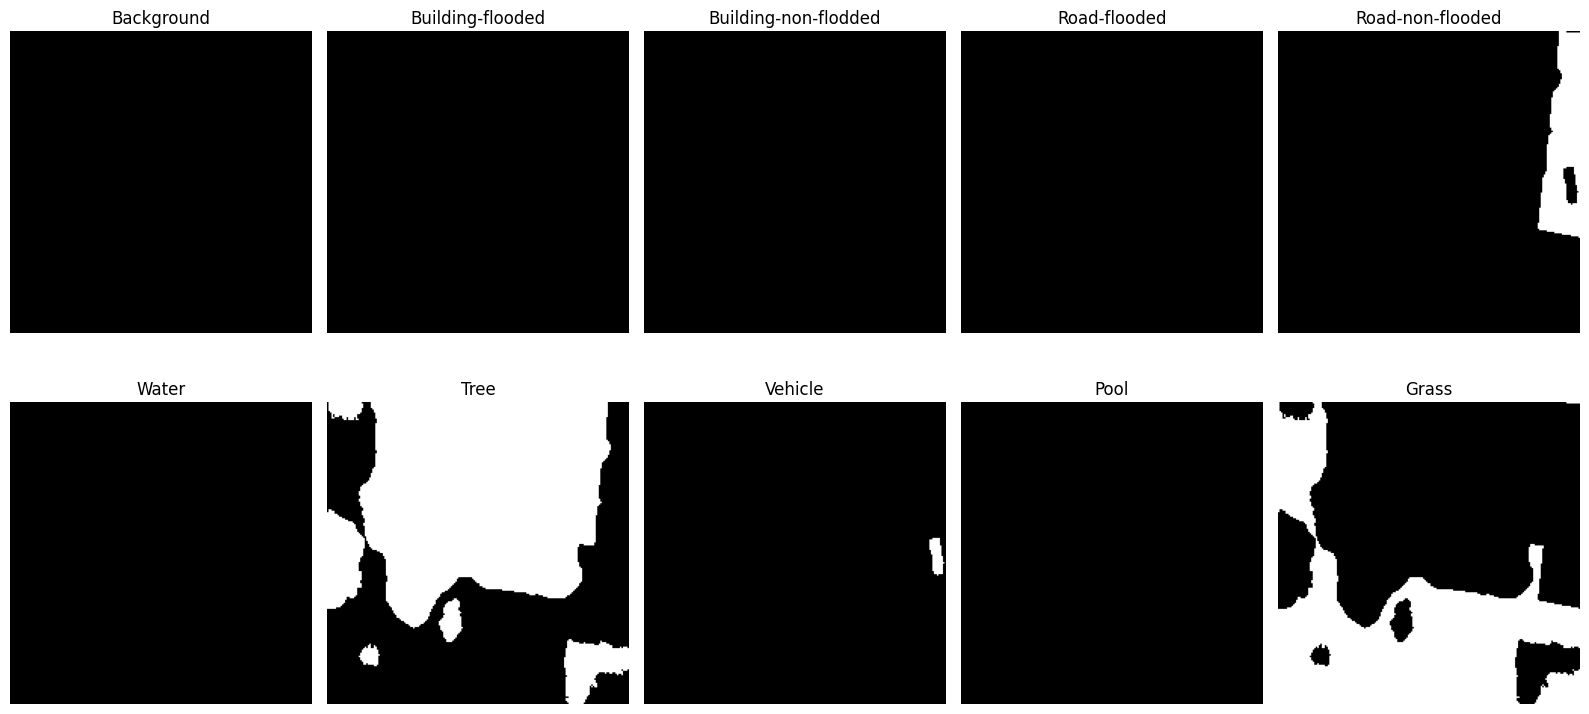

In [51]:
plt.figure(figsize=(16, 8)) 

for class_id in range(1, hyperparameters['IMAGE']['NUM_SEG_CLASSES']+1):
    plt.subplot(2, 5, class_id)
    plt.title(hyperparameters['IMAGE']['SEG_CLASS_NAMES'][class_id-1])
    
    #__img = np.array(mask_test==class_id-1, dtype=np.uint8)*255
    __img = test_masks_selected[class_id-1]
    
    plt.axis('off')
    plt.imshow(__img, cmap='gray')
    
plt.tight_layout()
plt.savefig(save_dir('masks_actual.eps'), format='eps')

# Colorful Segmentation Plot

In [52]:
# Red Green Blue Alpha
colors = [
    [0.0, 0.0, 0.0, 1.0],        # Background
    [1.0, 0.274, 0.274, 1.0],    # Building-Flooded (255, 70, 70)
    [1.0, 0.5, 0.0, 1.0],        # Building-non-flodded (255, 128, 0)
    [0.6, 0.6, 0.0, 1.0],        # Road-flooded (153, 153, 0)
    [0.5, 0.5, 0.5, 1.0],        # Road-non-flooded (128, 128, 128)
    [0.0, 1.0, 1.0, 1.0],        # Water (0, 255, 255)
    [0.0, 0.0, 1.0, 1.0],        # Tree (0, 0, 255)
    [1.0, 0.0, 1.0, 1.0],        # Vehicle (255, 0, 255)
    [1.0, 1.0, 0.0, 1.0],        # Pool (255, 255, 0)
    [0.0, 1.0, 0.0, 1.0],        # Grass (0, 255, 0)
]

### Predicted Masks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


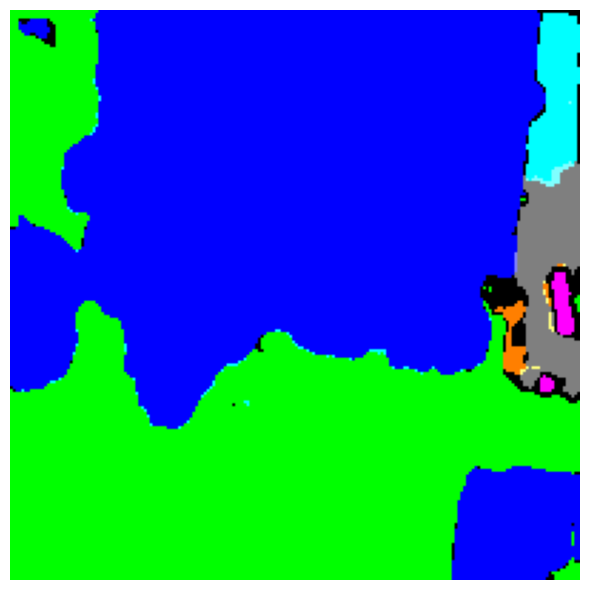

In [53]:
__img_color = np.zeros((hyperparameters['IMAGE']['RES'], hyperparameters['IMAGE']['RES'], hyperparameters['IMAGE']['IN_CHANNELS']))
    
for class_id in range(1, hyperparameters['IMAGE']['NUM_SEG_CLASSES']+1):
    
    #__img = np.array(mask_test==class_id-1, dtype=np.uint8)*255
    __img = predictions_threshold[class_id-1,:,:].cpu().detach().clone()
    
    r, g, b, a = colors[class_id-1]
    __img_color += np.stack([r*__img, g*__img, b*__img]).transpose(1,2,0)
    
    
plt.figure(figsize=(6, 6))
plt.imshow(__img_color, vmin=0, vmax=255)
plt.axis('off')
plt.tight_layout()
plt.savefig(save_dir('colorful_masks_prediction.eps'), format='eps')

### Actual Masks

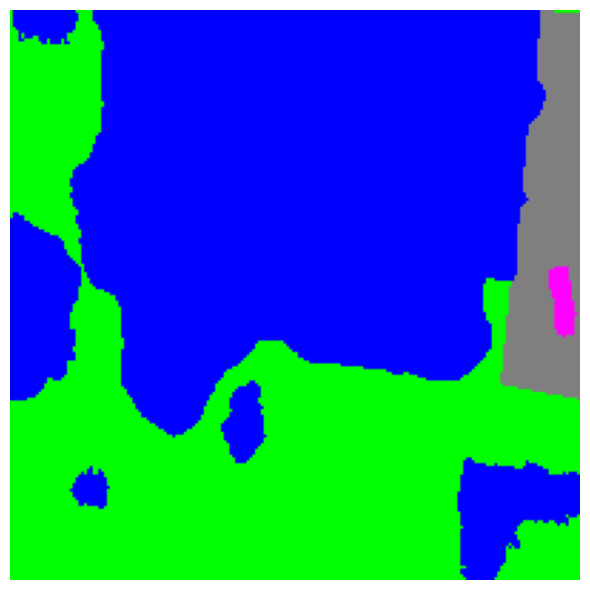

In [54]:
__img_color = np.zeros((hyperparameters['IMAGE']['RES'], hyperparameters['IMAGE']['RES'], hyperparameters['IMAGE']['IN_CHANNELS']))

for class_id in range(1, hyperparameters['IMAGE']['NUM_SEG_CLASSES']+1):

    __img = test_masks_selected[class_id-1].clone()
    
    r, g, b, a = colors[class_id-1]
    __img_color += np.stack([r*__img, g*__img, b*__img]).transpose(1,2,0)
    
    
plt.figure(figsize=(6, 6))
plt.imshow(__img_color, vmin=0, vmax=255)
plt.axis('off')
plt.tight_layout()
plt.savefig(save_dir('colorful_masks_actual.eps'), format='eps')